In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import joblib

In [5]:
df = pd.read_csv("../backend/data/preprocessed_data.csv")
print("Original columns:", df.columns.tolist())
print("Original shape:", df.shape)


Original columns: ['State', 'Crop', 'Year', 'Season', 'Yield', 'Annual_Rainfall', 'Fertilizer', 'Pesticide']
Original shape: (266733, 8)


In [7]:
# ========================================
# IMPROVEMENT 1: Remove 'Year' feature
# ========================================
# Year causes extrapolation issues when predicting for future years (2025+)
# Crop yield depends on weather/inputs, not calendar year
if 'Year' in df.columns:
    print("\n⚠️  Removing 'Year' column to prevent extrapolation issues...")
    df = df.drop('Year', axis=1)
    print("✅ Year removed. New columns:", df.columns.tolist())


⚠️  Removing 'Year' column to prevent extrapolation issues...
✅ Year removed. New columns: ['State', 'Crop', 'Season', 'Yield', 'Annual_Rainfall', 'Fertilizer', 'Pesticide']


In [9]:
# ========================================
# IMPROVEMENT 2: Prepare for LightGBM Native Categorical Support
# ========================================
# We'll keep data as integers for XGBoost/RF compatibility,
# but create a separate version with category dtype for LightGBM
df_encoded = df.copy()
encoders = {}  # Still save encoders for backend compatibility
categorical_cols = df_encoded.select_dtypes(include=['object']).columns.tolist()
print(f"\nCategorical columns: {categorical_cols}")
# Label encode categorical columns (keep as integers for now)
for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    encoders[col] = le  # Save for backend
print("✅ Label encoding done (as integers for compatibility).")



Categorical columns: ['State', 'Crop', 'Season']
✅ Label encoding done (as integers for compatibility).


In [11]:
# Split features and target
X = df_encoded.drop('Yield', axis=1)
y = df_encoded['Yield']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"\nTrain size: {len(X_train)}, Test size: {len(X_test)}")



Train size: 213386, Test size: 53347


In [15]:
# ========================================
# Baseline Models
# ========================================
print("\n" + "="*60)
print("Training Baseline Models...")
print("="*60)
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
xgb = XGBRegressor(random_state=42, n_estimators=300, learning_rate=0.1)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
# LightGBM with categorical feature support
# Convert categorical columns to 'category' dtype for LightGBM
X_train_lgb = X_train.copy()
X_test_lgb = X_test.copy()
for col in categorical_cols:
    if col in X_train_lgb.columns:
        X_train_lgb[col] = X_train_lgb[col].astype('category')
        X_test_lgb[col] = X_test_lgb[col].astype('category')
lgb = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42
)
lgb.fit(X_train_lgb, y_train, categorical_feature='auto')  # Auto-detect category dtype
lgb_pred = lgb.predict(X_test_lgb)
models = ['Random Forest', 'XGBoost', 'LightGBM']
predictions = [rf_pred, xgb_pred, lgb_pred]
print("\n📈 Model Performance Comparison (Before Tuning):")
for m, pred in zip(models, predictions):
    r2 = r2_score(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(f"{m}: R²={r2:.3f}, MAE={mae:.3f}, RMSE={rmse:.3f}")



Training Baseline Models...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 639
[LightGBM] [Info] Number of data points in the train set: 213386, number of used features: 6
[LightGBM] [Info] Start training from score 92.734397

📈 Model Performance Comparison (Before Tuning):
Random Forest: R²=0.880, MAE=22.066, RMSE=333.479
XGBoost: R²=0.880, MAE=22.681, RMSE=333.949
LightGBM: R²=0.880, MAE=22.738, RMSE=334.154


In [17]:
# ========================================
# Hyperparameter Tuning with Optuna
# ========================================
import optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 800),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', -1, 30),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'random_state': 42
    }
    model = LGBMRegressor(**params)
    # Use categorical_feature parameter with column names
    scores = cross_val_score(
        model, X_train_lgb, y_train, 
        cv=3, scoring='r2', n_jobs=-1,
        fit_params={'categorical_feature': 'auto'}
    )
    return scores.mean()
print("\n🚀 Running Optuna Hyperparameter Tuning for LightGBM...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, show_progress_bar=True)
print("\n✅ Best parameters found:")
print(study.best_params)

[I 2025-11-30 11:40:56,858] A new study created in memory with name: no-name-5d765d41-ce12-4ff7-b6f3-eba61f9173ef



🚀 Running Optuna Hyperparameter Tuning for LightGBM...


  0%|          | 0/30 [00:00<?, ?it/s]

C:\Users\Tejas\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[I 2025-11-30 11:41:05,556] Trial 0 finished with value: 0.8685503431818536 and parameters: {'n_estimators': 792, 'learning_rate': 0.19576534445262375, 'num_leaves': 33, 'max_depth': 7, 'min_child_samples': 32, 'subsample': 0.8688399380141593, 'colsample_bytree': 0.6627564590366753, 'reg_alpha': 0.5912090751575079, 'reg_lambda': 0.5323112522741991}. Best is trial 0 with value: 0.8685503431818536.
[I 2025-11-30 11:41:10,628] Trial 1 finished with value: 0.8691156243792251 and parameters: {'n_estimators': 351, 'learning_rate': 0.14572021324695297, 'num_leaves': 24, 'max_depth': 22, 'min_child_samples': 60, 'subsample': 0.9753033175227264, 'colsample_bytree': 0.8349204992298155, 'reg_alpha': 0.03021032619976738, 'reg_lambda': 0.5826672733304912}. Best is trial 1 with value: 0.8691156243792251.
[I 2025-11-30 11:41:23,441] Trial 2 finished with value: 0.8692110363406487 and parameters: {'n_estimators': 656, 'learning_rate': 0.043301838288332894, 'num_leaves': 141, 'max_depth': 30, 'min_chil

In [19]:
# ========================================
# Train Final Model with Best Parameters
# ========================================
best_params = study.best_params
best_lgb = LGBMRegressor(**best_params)
best_lgb.fit(X_train_lgb, y_train, categorical_feature='auto')
y_pred_best = best_lgb.predict(X_test_lgb)
r2_best = r2_score(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
print("\n🔥 Tuned LightGBM Results:")
print(f"R²={r2_best:.3f}, MAE={mae_best:.3f}, RMSE={rmse_best:.3f}")
lgb_pred = y_pred_best

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 639
[LightGBM] [Info] Number of data points in the train set: 213386, number of used features: 6
[LightGBM] [Info] Start training from score 92.734397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [21]:
# ========================================
# Final Comparison
# ========================================
print("\n📊 Final Model Performance Comparison:")
print("-" * 45)
models = ['Random Forest', 'XGBoost', 'LightGBM (Tuned)']
preds = [rf_pred, xgb_pred, lgb_pred]
for m, pred in zip(models, preds):
    r2 = r2_score(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(f"{m}: R²={r2:.3f}, MAE={mae:.3f}, RMSE={rmse:.3f}")


📊 Final Model Performance Comparison:
---------------------------------------------
Random Forest: R²=0.880, MAE=22.066, RMSE=333.479
XGBoost: R²=0.880, MAE=22.681, RMSE=333.949
LightGBM (Tuned): R²=0.881, MAE=27.304, RMSE=332.966


In [23]:
# ========================================
# K-Fold Cross Validation
# ========================================
print("\n📚 K-Fold Cross Validation (5 folds) Results:")
print("-" * 50)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
models_dict = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, n_estimators=300, learning_rate=0.1),
    'LightGBM (Tuned)': LGBMRegressor(**best_params)
}
kfold_results = {}
# Prepare category version of full dataset for LightGBM
X_lgb = X.copy()
for col in categorical_cols:
    if col in X_lgb.columns:
        X_lgb[col] = X_lgb[col].astype('category')
for name, model in models_dict.items():
    if name == 'LightGBM (Tuned)':
        # Use categorical features in CV
        scores = cross_val_score(
            model, X_lgb, y, cv=kfold, scoring='r2', n_jobs=-1,
            fit_params={'categorical_feature': 'auto'}
        )
    else:
        scores = cross_val_score(model, X, y, cv=kfold, scoring='r2', n_jobs=-1)
    
    kfold_results[name] = scores
    print(f"{name}: Mean R² = {scores.mean():.3f}, Std = {scores.std():.3f}")
print("\n🔍 Comparison: Cross-Validation vs. Test Performance")
print("-" * 60)
for m, pred in zip(models, preds):
    cv_mean = kfold_results[m].mean()
    test_r2 = r2_score(y_test, pred)
    print(f"{m}: CV R²={cv_mean:.3f} | Test R²={test_r2:.3f}")
# Select best model
test_scores = {}
for m, pred in zip(models, preds):
    test_r2 = r2_score(y_test, pred)
    test_scores[m] = test_r2
best_model_name = max(test_scores, key=lambda m: test_scores[m])
best_test_r2 = test_scores[best_model_name]
print(f"\n🏆 Best overall model (best Test R² accuracy): {best_model_name}")
print(f"   Test R² = {best_test_r2:.3f}")


📚 K-Fold Cross Validation (5 folds) Results:
--------------------------------------------------
Random Forest: Mean R² = 0.871, Std = 0.019
XGBoost: Mean R² = 0.872, Std = 0.020


C:\Users\Tejas\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


LightGBM (Tuned): Mean R² = 0.874, Std = 0.020

🔍 Comparison: Cross-Validation vs. Test Performance
------------------------------------------------------------
Random Forest: CV R²=0.871 | Test R²=0.880
XGBoost: CV R²=0.872 | Test R²=0.880
LightGBM (Tuned): CV R²=0.874 | Test R²=0.881

🏆 Best overall model (best Test R² accuracy): LightGBM (Tuned)
   Test R² = 0.881


C:\Users\Tejas\AppData\Local\Temp\ipykernel_4440\2955042690.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rf_feat_imp, x='Importance', y='Feature', ax=axes[0], palette='Blues_r')
C:\Users\Tejas\AppData\Local\Temp\ipykernel_4440\2955042690.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=xgb_feat_imp, x='Importance', y='Feature', ax=axes[1], palette='Greens_r')
C:\Users\Tejas\AppData\Local\Temp\ipykernel_4440\2955042690.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=lgb_feat_imp, x='Importance', y='Feature', ax


📊 Feature importance plot saved as 'feature_importance_comparison.png'


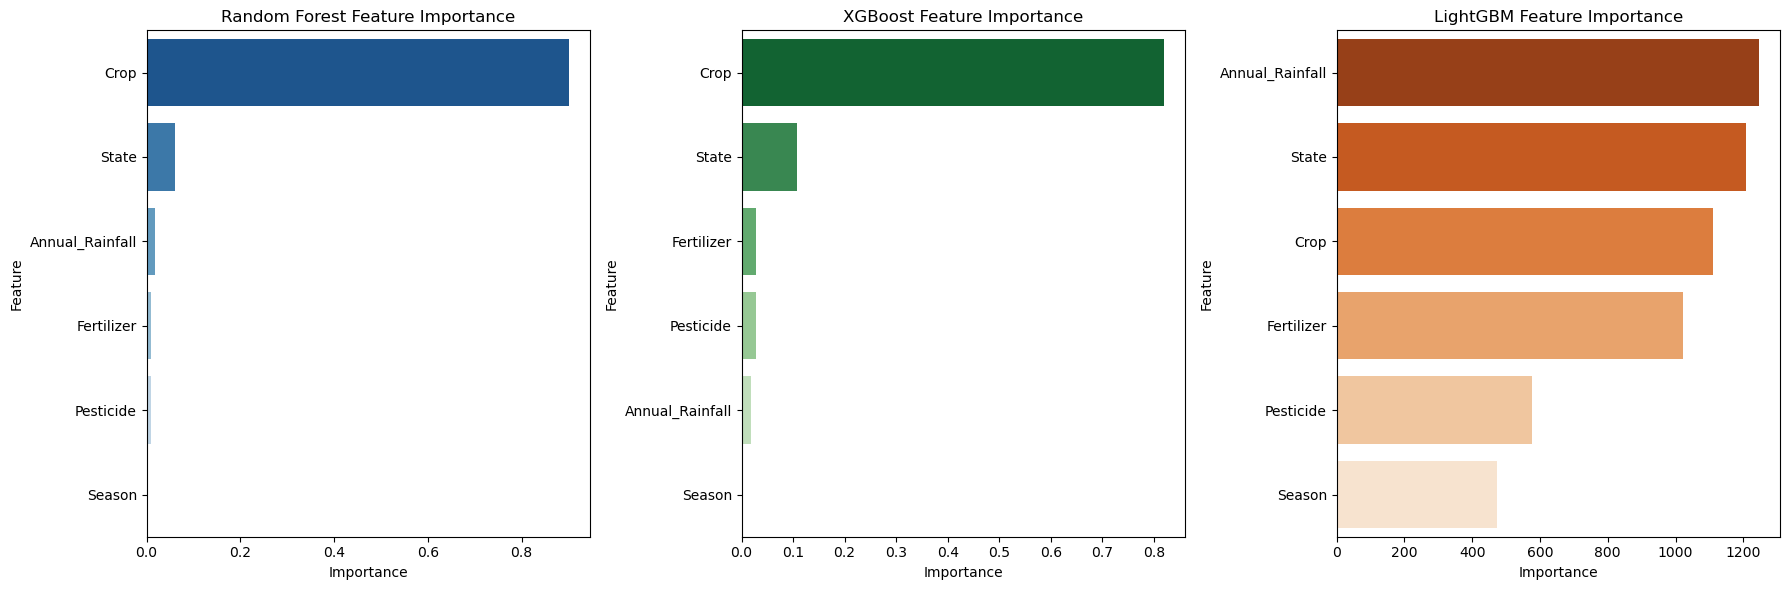

In [25]:
# ========================================
# Feature Importance Visualization
# ========================================
rf_importances = rf.feature_importances_
rf_feat_imp = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf_importances})
rf_feat_imp = rf_feat_imp.sort_values('Importance', ascending=False).head(10)
xgb_importances = xgb.feature_importances_
xgb_feat_imp = pd.DataFrame({'Feature': X_train.columns, 'Importance': xgb_importances})
xgb_feat_imp = xgb_feat_imp.sort_values('Importance', ascending=False).head(10)
lgb_importances = best_lgb.feature_importances_
lgb_feat_imp = pd.DataFrame({'Feature': X_train_lgb.columns, 'Importance': lgb_importances})
lgb_feat_imp = lgb_feat_imp.sort_values('Importance', ascending=False).head(10)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.barplot(data=rf_feat_imp, x='Importance', y='Feature', ax=axes[0], palette='Blues_r')
axes[0].set_title("Random Forest Feature Importance")
sns.barplot(data=xgb_feat_imp, x='Importance', y='Feature', ax=axes[1], palette='Greens_r')
axes[1].set_title("XGBoost Feature Importance")
sns.barplot(data=lgb_feat_imp, x='Importance', y='Feature', ax=axes[2], palette='Oranges_r')
axes[2].set_title("LightGBM Feature Importance")
plt.tight_layout()
plt.savefig('feature_importance_comparison.png', dpi=300, bbox_inches='tight')
print("\n📊 Feature importance plot saved as 'feature_importance_comparison.png'")
plt.show()

In [27]:
# ========================================
# Save Model and Artifacts
# ========================================
# IMPORTANT: Feature order WITHOUT 'Year'
feature_order = X_train.columns.tolist()
print(f"\n📝 Feature order (without Year): {feature_order}")
joblib.dump(best_lgb, '../backend/ml/best_model.pkl')
joblib.dump(encoders, '../backend/ml/encoders.pkl')
joblib.dump(feature_order, '../backend/ml/feature_order.pkl')
print("\n✅ Model and artifacts saved successfully!")
print("   - best_model.pkl")
print("   - encoders.pkl")
print("   - feature_order.pkl")
print("\n" + "="*60)
print("🎉 Training Complete!")
print("="*60)
print("\n⚠️  IMPORTANT: Update your backend preprocess.py:")
print("   - Remove the line that sets Year = datetime.now().year")
print("   - The model no longer expects a Year feature")
print("="*60)


📝 Feature order (without Year): ['State', 'Crop', 'Season', 'Annual_Rainfall', 'Fertilizer', 'Pesticide']

✅ Model and artifacts saved successfully!
   - best_model.pkl
   - encoders.pkl
   - feature_order.pkl

🎉 Training Complete!

⚠️  IMPORTANT: Update your backend preprocess.py:
   - Remove the line that sets Year = datetime.now().year
   - The model no longer expects a Year feature
